In [1]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import keras
from keras.preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from tensorflow.keras.callbacks import TensorBoard
import time

In [2]:
model_name = "raw_500"
NAME = "Covid-"+model_name+"-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

CATEGORIES = ["covid", "normal"]
DATADIR = "D:/Project2022/res/split_dataset/original/train"


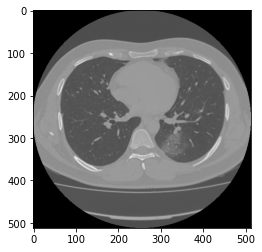

In [178]:
for categoty in CATEGORIES:
    path = os.path.join(DATADIR, categoty)  # path to Covid or Nprmal
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        break
    break

In [5]:
# Data Augmentation

IMAGE_SIZE    = (244, 244)

BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 500
LEARNING_RATE =0.0005 

train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip= True ,
    validation_split = 0.2)

In [180]:
print("Training samples:")
train_batches = train_datagen.flow_from_directory(DATADIR,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="binary")

print("\n Validation samples: ")
                                                  

valid_batches = train_datagen.flow_from_directory(DATADIR,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="binary" )





Training samples:
Found 8988 images belonging to 2 classes.

 Validation samples: 
Found 2245 images belonging to 2 classes.


In [8]:
# Output classes
train_batches.class_indices

{'covid': 0, 'normal': 1}

In [71]:

df = pd.DataFrame()
df["labels"] = list(train_batches.classes)

In [44]:
df["labels"].value_counts()

0    4576
1    4412
Name: labels, dtype: int64

In [9]:
len(train_batches.classes)

8988

##  Distribution of classes

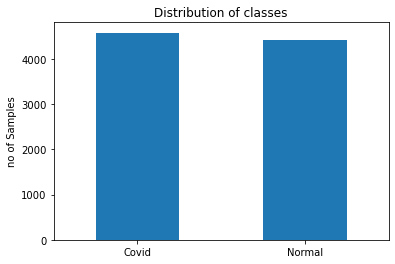

In [46]:
df["labels"].value_counts().plot(kind='bar')
plt.xticks([0,1], ["Covid", "Normal"], rotation='horizontal')
plt.ylabel('no of Samples')
plt.title('Distribution of classes')
plt.show()

In [6]:
# Model Structure
model = Sequential()

model.add(Conv2D( 32, kernel_size=(3,3),activation='relu',input_shape=(244, 244,3)))

model.add(Conv2D( 128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D( 64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D( 64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
#remove dropout - 0.2
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss = keras.losses.binary_crossentropy, optimizer = 'adam', metrics = ['accuracy'])

In [185]:
model = Sequential([
            
    Conv2D(filters=32,kernel_size=(3,3),  input_shape = (244, 244,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

model.compile(loss = keras.losses.binary_crossentropy, optimizer = 'adam', metrics = ['accuracy'])




In [186]:
#temp
result = model.fit_generator(train_batches,
                        steps_per_epoch = len(train_batches),
                        validation_data = valid_batches,
                        validation_steps = len(valid_batches),
                        epochs= 10
                        )

c:\Users\ranji\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
281/281 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.7743WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001F8F5945828> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

In [7]:
result = model.fit_generator(train_batches,
                        steps_per_epoch = len(train_batches),
                        validation_data = valid_batches,
                        validation_steps = len(valid_batches),
                        epochs= NUM_EPOCHS,
                        callbacks=[tensorboard])

model.save("D:/Project2022/models/image/"+model_name+".h5")


c:\Users\ranji\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
281/281 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.7741WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002BD729E0CA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

In [194]:
model_name = "temp_10"
model.save("D:/Project2022/models/image/"+model_name+".h5")

In [3]:
model = keras.models.load_model("D:/Project2022/models/image/raw_500.h5")

## Evaluating the model on Test dataset

In [6]:
test_dir = "D:/Project2022/res/split_dataset/original/test"

test_datagen = image.ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        seed=42,      
        class_mode="binary")

Found 2809 images belonging to 2 classes.


In [7]:
x = model.evaluate(eval_generator,
                       steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                       use_multiprocessing = False,
                       verbose = 1,
                       workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
88/88 [==============================] - 10s 12ms/step - loss: 0.0312 - accuracy: 0.9886
Test loss: 0.031245898455381393
Test accuracy: 0.9886363744735718


In [8]:
pred = model.predict(eval_generator,len(eval_generator.classes),verbose=1)
print("Predictions finished")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2809/2809 [==============================] - 32s 11ms/step
Predictions finished


In [9]:
y_test = eval_generator.classes
y_pred = (pred > 0.5).astype("int32")

In [10]:
from sklearn.metrics import classification_report 
print(classification_report(eval_generator.classes, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.99      0.98      0.99      1430
      Normal       0.98      0.99      0.99      1379

    accuracy                           0.99      2809
   macro avg       0.99      0.99      0.99      2809
weighted avg       0.99      0.99      0.99      2809



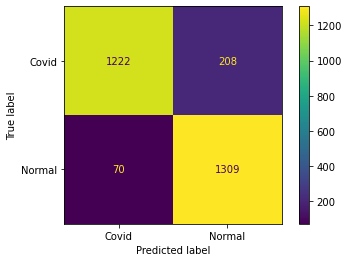

In [192]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(eval_generator.classes, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()


In [57]:
from tf_explain.core.grad_cam import GradCAM

In [129]:
IMAGE_PATH = "D:/Project2022/res/split_dataset/original/test/covid/sample_covid_3.png"
#model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(244, 244))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.reshape(244,244,3)
img.shape


(244, 244, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


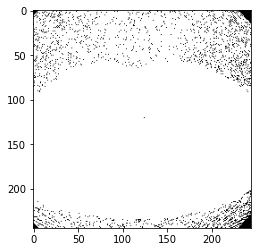

In [130]:
plt.imshow(img)

In [95]:
model = keras.models.load_model("D:/Project2022/models/image/raw_500.h5")

In [195]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 121, 121, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 119, 119, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 59, 59, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 57, 57, 64)       

In [201]:
IMAGE_PATH = "D:/Project2022/res/split_dataset/original/test/covid/sample_covid_567.png"
#model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(244, 244))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.reshape(1,244,244,3)
img.shape

(1, 244, 244, 3)

In [135]:
pred = model.predict(img)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 153ms/step


In [136]:
y_pred = (pred > 0.5).astype("int32")
print(y_pred)

[[0]]


In [202]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [203]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [139]:
model = keras.models.load_model("D:/Project2022/models/image/raw_500.h5")


In [196]:
model.layers[-1].activation = None

In [197]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 121, 121, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 119, 119, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 59, 59, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 57, 57, 64)       

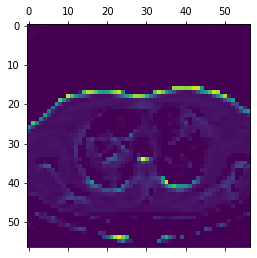

In [204]:
heatmap = make_gradcam_heatmap(img, model, "conv2d_8")
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [206]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

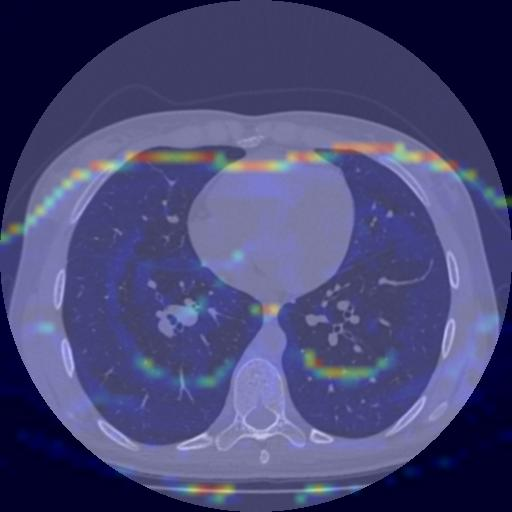

In [208]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))



IMAGE_PATH = "D:/Project2022/res/split_dataset/original/test/normal/sample_normal_89.png"
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(244, 244))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.reshape(1,244,244,3)

save_and_display_gradcam(IMAGE_PATH, heatmap)